In [1]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt

## Algoritmo PSO

In [2]:
class Particula:
    def __init__(self, dimensoes: int, limite_min: float, limite_max: float):
        self.limite_min = limite_min
        self.limite_max = limite_max
    
        self.posicao = np.random.uniform(limite_min, limite_max, dimensoes)

        velocidade_min = limite_min * 0.2
        velocidade_max = limite_max * 0.2
        self.velocidade = np.random.uniform(velocidade_min, velocidade_max, dimensoes)

        self.best_posicao = np.copy(self.posicao)
        self.best_fitness = None

    def avaliar_particula(self, funcao_fitness):
        avaliacao_particula = funcao_fitness(self.posicao)

        if (self.best_fitness is None) or (avaliacao_particula < self.best_fitness):
            self.best_posicao = np.copy(self.posicao)
            self.best_fitness = avaliacao_particula
        
        return avaliacao_particula
    
    def nova_velocidade(self, w, c1, c2, best_posicoes_vizinhas, gbest):
        r1 = random.random()
        r2 = random.random()
        
        if best_posicoes_vizinhas is not None:
            fitness_vizinhos = [p.best_fitness for p in best_posicoes_vizinhas]
            indice_melhor_vizinho = np.argmin(fitness_vizinhos)

            
            best_local = best_posicoes_vizinhas[indice_melhor_vizinho].best_posicao 
        else:
            best_local = gbest
        
        self.velocidade = (w * self.velocidade) + (c1 * r1 * (self.best_posicao - self.posicao)) + (c2 * r2 * (best_local - self.posicao))

    def nova_posicao(self):
        self.posicao += self.velocidade

        for i in range(len(self.posicao)):
            if self.posicao[i] > self.limite_max:
                self.posicao[i] = self.limite_max
            elif self.posicao[i] < self.limite_min:
                self.posicao[i] = self.limite_min

class PSO:
    def __init__(self, dimensoes: int, limite_min: float, limite_max: float, quant_particulas: int, quant_iteracoes: int, funcao_fitness, w: float, wMax:float, wMin:float, c1: float, c2: float, tipo_cooperacao: str = 'GLOBAL'):
        self.dimensoes = dimensoes
        self.limite_min = limite_min
        self.limite_max = limite_max
        self.quant_particulas = quant_particulas
        self.quant_iteracoes = quant_iteracoes
        self.funcao_fitness = funcao_fitness
        self.w = w
        self.wMax = wMax
        self.wMin = wMin
        self.c1 = c1
        self.c2 = c2
        self.tipo_cooperacao = tipo_cooperacao
        
        self.best_posicao_global = None
        self.best_fitness_global = float('inf')
        self.iteracao_best = 0

        self.historico_fitness_global = []
    
    def gerar_enxame(self):
        return [Particula(dimensoes=self.dimensoes, 
                          limite_min=self.limite_min, 
                          limite_max=self.limite_max) 
                for _ in range(self.quant_particulas)]
    
    @staticmethod
    def sphere(particula):
        return sum(x ** 2 for x in particula)
    
    @staticmethod
    def rastrigin(particula):
        resultado = 0
        for i in particula:
            numero = 2 * 3.1415 * i
            p = (numero / 180) * math.pi
            resultado += (i**2) - (10 * math.cos(p)) + 10    
        return resultado
    
    @staticmethod
    def rosenbrock(particula):
        resultado = 0
        for i in range(0, (len(particula)-1)):
            resultado += 100 * (particula[i+1] - particula[i]**2)**2 + (particula[i] - 1)**2   
        return resultado
    
    def avaliar_enxame(self, enxame, iteracao):      
        avaliacao_enxame = np.array([])
        for particula in enxame:
            avaliacao_enxame = np.append(avaliacao_enxame, particula.avaliar_particula(self.funcao_fitness))
        
        fitness_min = avaliacao_enxame.min()

        if fitness_min < self.best_fitness_global:
            indice_best_global = np.where(avaliacao_enxame == fitness_min)[0][0] 
            particula_best = enxame[indice_best_global]

            self.best_fitness_global = fitness_min
            self.best_posicao_global = particula_best.posicao
            self.iteracao_best = iteracao

            self.historico_fitness_global.append((iteracao, self.best_fitness_global))
    
    def calcular_decaimento_linear(self, iteracao):
        return (self.wMax  - self.wMin) * ((self.quant_iteracoes - iteracao) / self.quant_iteracoes) + self.wMin

    def calcular_posicao_enxame(self, enxame, iteracao):

        if (self.w is None and self.wMax is not None and self.wMin is not None):
            w = self.calcular_decaimento_linear(iteracao)
        elif (self.w is not None and self.wMax is None and self.wMin is None):
            w = self.w

        for i, particula in enumerate(enxame):
            if self.tipo_cooperacao == 'GLOBAL':
                particula.nova_velocidade(w, self.c1, self.c2, best_posicoes_vizinhas=None, gbest= self.best_posicao_global)
            
            elif self.tipo_cooperacao == 'LOCAL':
                if i == 0:
                    vizinho_esquerdo = enxame[-1]  
                    vizinho_direito = enxame[1]
                elif i == len(enxame) - 1:
                    vizinho_esquerdo = enxame[-2] 
                    vizinho_direito = enxame[0]                     
                else: 
                    vizinho_esquerdo = enxame[i - 1]
                    vizinho_direito = enxame[i + 1]
                
                particula.nova_velocidade(w, self.c1, self.c2, best_posicoes_vizinhas=[vizinho_esquerdo, vizinho_direito], gbest=None)
            
            particula.nova_posicao()

    def plotar_convergencia(self):
        iteracoes, fitness = zip(*self.historico_fitness_global)
        plt.figure(figsize=(10, 6))
        plt.plot(iteracoes, fitness, marker='o', linestyle='-', color='b')
        plt.xlabel('Iteração')
        plt.ylabel('Melhor Fitness Global')
        plt.title('Convergência do PSO')
        plt.grid(True)
        plt.show()
        
    def executar(self):
        enxame = self.gerar_enxame()
        for iteracao in range(1, self.quant_iteracoes + 1):
            self.avaliar_enxame(enxame=enxame, iteracao=iteracao)
            self.calcular_posicao_enxame(enxame=enxame, iteracao=iteracao)

### Execução do PSO - Sphere

BEST FITNESS GLOBAL = 0.6761830635687829
BEST POSICAO GLOBAL = [ 0.13120666 -0.16291678  0.2593149   0.01718594  0.06640917 -0.21947179
  0.23309382  0.21256843  0.01112793 -0.3884378   0.02359946 -0.02231352
  0.10055611  0.07896636  0.01982256 -0.00963379  0.17742639  0.03171291
 -0.02286749  0.27928744 -0.21906902 -0.05128139 -0.0841128  -0.01155068
  0.0679035   0.05430305 -0.20806135  0.1201925   0.03527825 -0.0922774 ]
ITERACAO DO BEST = 10000


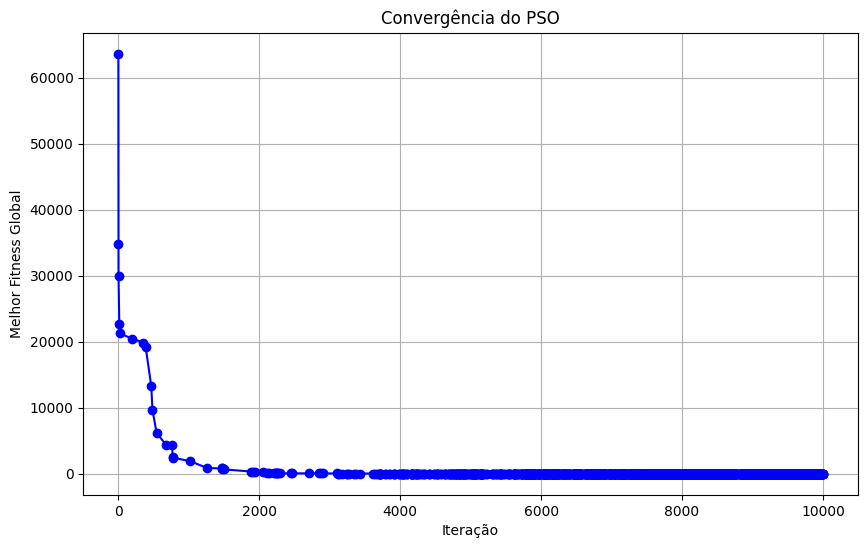

In [19]:
# Caso queira a execução com o Fator de Inércia constante coloque 'None' nos parâmetros wMax e wMin
# Caso queira a execução com o Fator de Inércia com decaimento linear coloque 'None' no parâmetro w

pso = PSO(dimensoes= 30, 
          limite_min= -100.0, 
          limite_max= 100.0, 
          quant_particulas= 50, 
          quant_iteracoes= 10000, 
          funcao_fitness = PSO.sphere,
          w= None,
          wMax= 1,
          wMin= 0.5,
          c1=2.05, 
          c2=2.05,
          tipo_cooperacao='GLOBAL')

pso.executar()

print(f'BEST FITNESS GLOBAL = {pso.best_fitness_global}')
print(f'BEST POSICAO GLOBAL = {pso.best_posicao_global}')
print(f'ITERACAO DO BEST = {pso.iteracao_best}')

pso.plotar_convergencia()


### Execução do PSO - Rastrigin

BEST FITNESS GLOBAL = 0.13129344853095404
BEST POSICAO GLOBAL = [-0.00993954 -0.05248796  0.00456463  0.01754601  0.01956072  0.13614945
  0.027785   -0.06161661  0.0133837  -0.03027863  0.05691878 -0.00535731
 -0.01813294  0.00256115 -0.12321975  0.17128396  0.00453214  0.00851005
 -0.02408475 -0.13930527 -0.05791717 -0.05042437 -0.03536147 -0.01518088
  0.06017283 -0.06882141  0.06723362 -0.07330672  0.04737827  0.00166677]
ITERACAO DO BEST = 8321


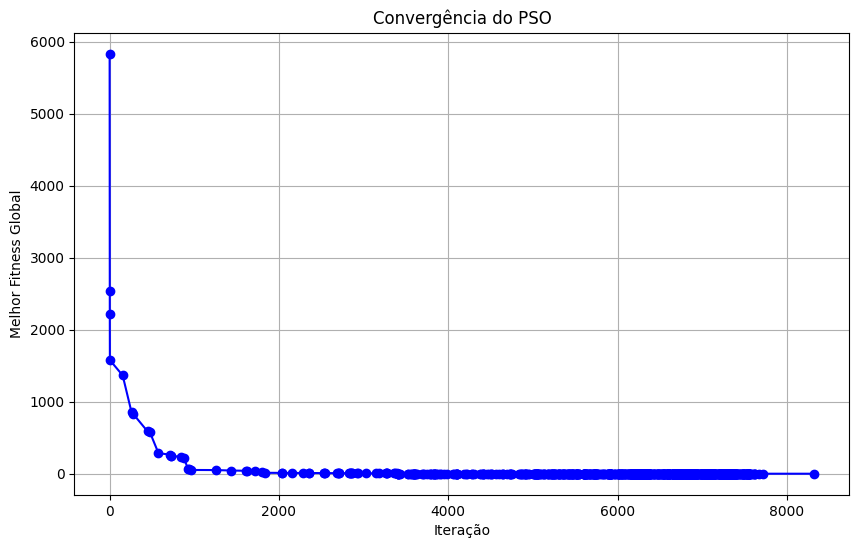

In [20]:
# Caso queira a execução com o Fator de Inércia constante coloque 'None' nos parâmetros wMax e wMin
# Caso queira a execução com o Fator de Inércia com decaimento linear coloque 'None' no parâmetro w

pso = PSO(dimensoes= 30, 
          limite_min= -30.0, 
          limite_max= 30, 
          quant_particulas= 50, 
          quant_iteracoes= 10000, 
          funcao_fitness = PSO.rastrigin,
          w= None,
          wMax= 1,
          wMin= 0.5,
          c1=2.05, 
          c2=2.05,
          tipo_cooperacao='GLOBAL')

pso.executar()

print(f'BEST FITNESS GLOBAL = {pso.best_fitness_global}')
print(f'BEST POSICAO GLOBAL = {pso.best_posicao_global}')
print(f'ITERACAO DO BEST = {pso.iteracao_best}')

pso.plotar_convergencia()


### Execução do PSO - Rosenbrock

BEST FITNESS GLOBAL = 28.154443884753686
BEST POSICAO GLOBAL = [ 0.34250622  0.10913477  0.01222368 -0.00615516  0.01228129  0.01526855
  0.00095509  0.00044291  0.0092045   0.00146642  0.01294073  0.01431714
  0.01785698  0.01411421  0.01916799  0.0162743   0.02165405  0.00769492
  0.00658074  0.00127835  0.02589172  0.0041169   0.01406036  0.01455024
 -0.0119267   0.02406854  0.01089274  0.00735157  0.00177043 -0.00537883]
ITERACAO DO BEST = 9999


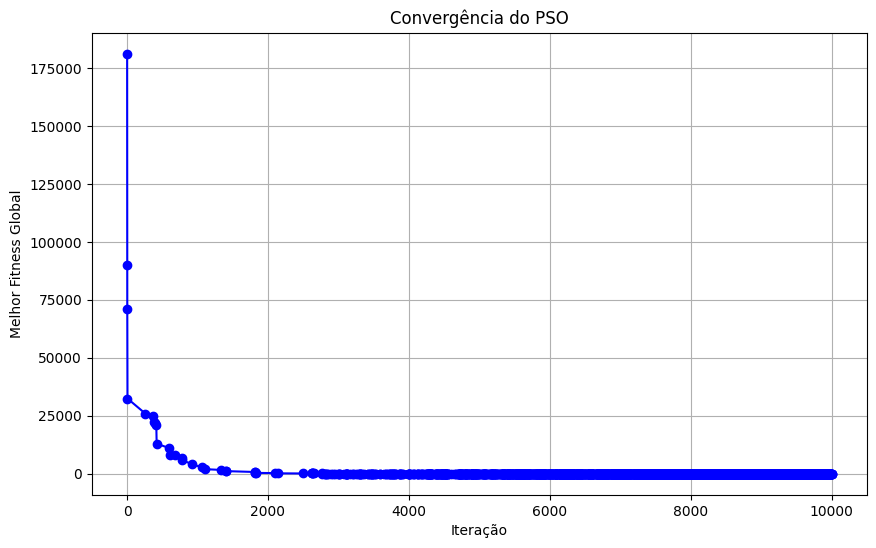

In [17]:
# Caso queira a execução com o Fator de Inércia constante coloque 'None' nos parâmetros wMax e wMin
# Caso queira a execução com o Fator de Inércia com decaimento linear coloque 'None' no parâmetro w

pso = PSO(dimensoes= 30, 
          limite_min= -5.12, 
          limite_max= 5.12, 
          quant_particulas= 50, 
          quant_iteracoes= 10000, 
          funcao_fitness = PSO.rosenbrock,
          w= None,
          wMax= 1,
          wMin= 0.5,
          c1=2.05, 
          c2=2.05,
          tipo_cooperacao='LOCAL')

pso.executar()

print(f'BEST FITNESS GLOBAL = {pso.best_fitness_global}')
print(f'BEST POSICAO GLOBAL = {pso.best_posicao_global}')
print(f'ITERACAO DO BEST = {pso.iteracao_best}')

pso.plotar_convergencia()


## Cenários de testes
Execução de diversos cenários de testes, alternando: 
- Função fitness
- Tipo de cooperação
- Tipo do fator de inércia 

Esses cenários tem como objetivo exibir uma comparação dos valores gerados através de um Gráfico Boxplot.

### Cenário com Função fitness: Sphere

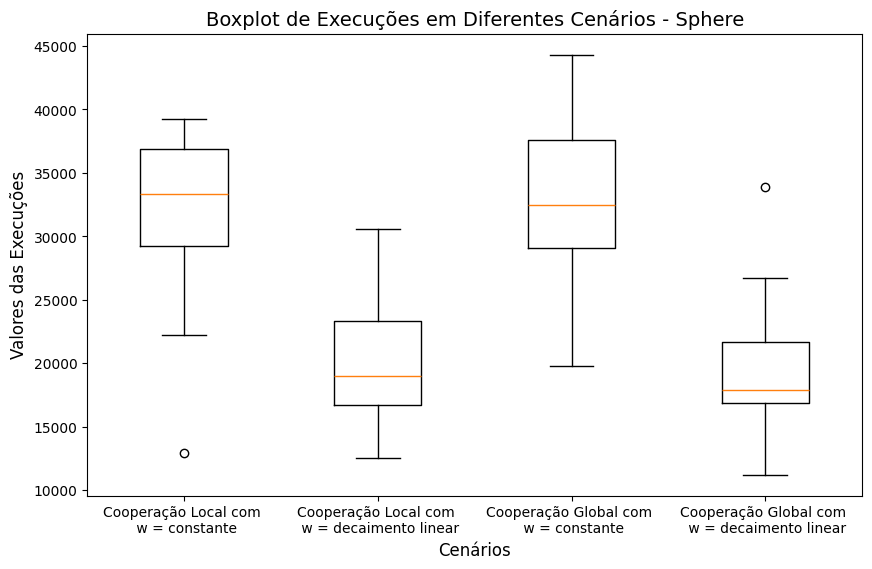

In [4]:
cenario_1 = []
for _ in range(30):
    pso = PSO(dimensoes= 30, limite_min= -100.0, limite_max= 100.0, quant_particulas=20, quant_iteracoes=30, 
            funcao_fitness = PSO.sphere, w= 1, wMax= None, wMin= None, c1=2.05, c2=2.05, tipo_cooperacao='LOCAL')
    pso.executar()
    cenario_1.append(pso.best_fitness_global)

cenario_2 = []
for _ in range(30):
    pso = PSO(dimensoes= 30, limite_min= -100.0, limite_max= 100.0, quant_particulas=20, quant_iteracoes=30, 
            funcao_fitness = PSO.sphere, w= None, wMax= 1.0, wMin= 0.5, c1=2.05, c2=2.05, tipo_cooperacao='LOCAL')
    pso.executar()
    cenario_2.append(pso.best_fitness_global)

cenario_3 = []
for _ in range(30):
    pso = PSO(dimensoes= 30, limite_min= -100.0, limite_max= 100.0, quant_particulas=20, quant_iteracoes=30, 
            funcao_fitness = PSO.sphere, w= 1, wMax= None, wMin= None, c1=2.05, c2=2.05, tipo_cooperacao='GLOBAL')
    pso.executar()
    cenario_3.append(pso.best_fitness_global)

cenario_4 = []
for _ in range(30):
    pso = PSO(dimensoes= 30 , limite_min= -100.0, limite_max= 100.0, quant_particulas=20, quant_iteracoes=30, 
            funcao_fitness = PSO.sphere, w= None, wMax= 1, wMin= 0.5, c1=2.05, c2=2.05, tipo_cooperacao='GLOBAL')
    pso.executar()
    cenario_4.append(pso.best_fitness_global)


dados = [cenario_1, cenario_2, cenario_3, cenario_4]

plt.figure(figsize=(10, 6))
plt.boxplot(dados, tick_labels=['Cooperação Local com \n w = constante', 'Cooperação Local com \n w = decaimento linear', 'Cooperação Global com \n w = constante', 'Cooperação Global com \n w = decaimento linear'])

plt.title('Boxplot de Execuções em Diferentes Cenários - Sphere', fontsize=14)
plt.xlabel('Cenários', fontsize=12)
plt.ylabel('Valores das Execuções', fontsize=12)

plt.show()

### Cenário com Função fitness: Rastrigin

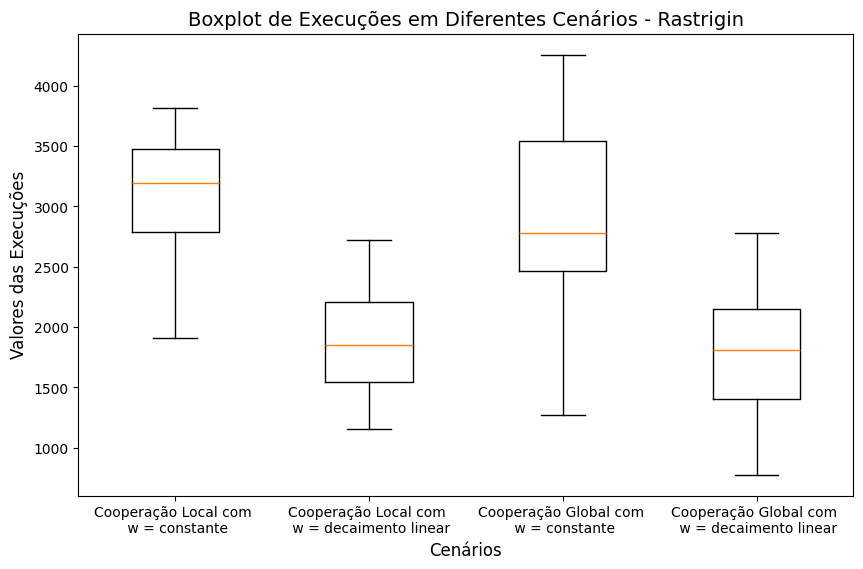

In [5]:
cenario_1 = []
for _ in range(30):
    pso = PSO(dimensoes= 30, limite_min= -30.0, limite_max= 30.0, quant_particulas=20, quant_iteracoes=30, 
            funcao_fitness = PSO.rastrigin, w= 1, wMax= None, wMin= None, c1=2.05, c2=2.05, tipo_cooperacao='LOCAL')
    pso.executar()
    cenario_1.append(pso.best_fitness_global)

cenario_2 = []
for _ in range(30):
    pso = PSO(dimensoes= 30, limite_min= -30.0, limite_max= 30.0, quant_particulas=20, quant_iteracoes=30, 
            funcao_fitness = PSO.rastrigin, w= None, wMax= 1.0, wMin= 0.5, c1=2.05, c2=2.05, tipo_cooperacao='LOCAL')
    pso.executar()
    cenario_2.append(pso.best_fitness_global)

cenario_3 = []
for _ in range(30):
    pso = PSO(dimensoes= 30, limite_min= -30.0, limite_max= 30.0, quant_particulas=20, quant_iteracoes=30, 
            funcao_fitness = PSO.rastrigin, w= 1, wMax= None, wMin= None, c1=2.05, c2=2.05, tipo_cooperacao='GLOBAL')
    pso.executar()
    cenario_3.append(pso.best_fitness_global)

cenario_4 = []
for _ in range(30):
    pso = PSO(dimensoes= 30 , limite_min= -30.0, limite_max= 30.0, quant_particulas=20, quant_iteracoes=30, 
            funcao_fitness = PSO.rastrigin, w= None, wMax= 1, wMin= 0.5, c1=2.05, c2=2.05, tipo_cooperacao='GLOBAL')
    pso.executar()
    cenario_4.append(pso.best_fitness_global)


dados = [cenario_1, cenario_2, cenario_3, cenario_4]

plt.figure(figsize=(10, 6))
plt.boxplot(dados, tick_labels=['Cooperação Local com \n w = constante', 'Cooperação Local com \n w = decaimento linear', 'Cooperação Global com \n w = constante', 'Cooperação Global com \n w = decaimento linear'])

plt.title('Boxplot de Execuções em Diferentes Cenários - Rastrigin', fontsize=14)
plt.xlabel('Cenários', fontsize=12)
plt.ylabel('Valores das Execuções', fontsize=12)

plt.show()

### Cenário com Função fitness: Rosenbrock

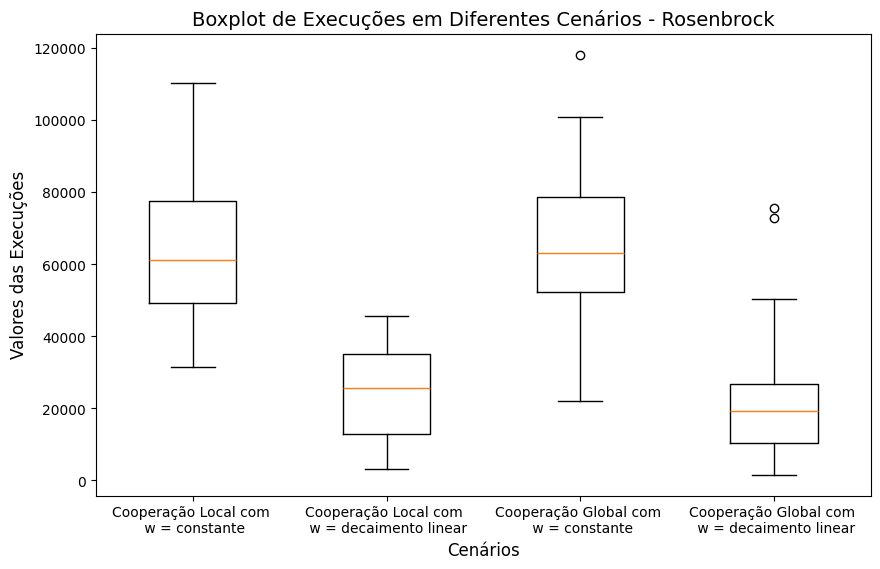

In [6]:
cenario_1 = []
for _ in range(30):
    pso = PSO(dimensoes= 30, limite_min= -5.12, limite_max= 5.12, quant_particulas=20, quant_iteracoes=30, 
            funcao_fitness = PSO.rosenbrock, w= 1, wMax= None, wMin= None, c1=2.05, c2=2.05, tipo_cooperacao='LOCAL')
    pso.executar()
    cenario_1.append(pso.best_fitness_global)

cenario_2 = []
for _ in range(30):
    pso = PSO(dimensoes= 30, limite_min= -5.12, limite_max= 5.12, quant_particulas=20, quant_iteracoes=30, 
            funcao_fitness = PSO.rosenbrock, w= None, wMax= 1.0, wMin= 0.5, c1=2.05, c2=2.05, tipo_cooperacao='LOCAL')
    pso.executar()
    cenario_2.append(pso.best_fitness_global)

cenario_3 = []
for _ in range(30):
    pso = PSO(dimensoes= 30, limite_min= -5.12, limite_max= 5.12, quant_particulas=20, quant_iteracoes=30, 
            funcao_fitness = PSO.rosenbrock, w= 1, wMax= None, wMin= None, c1=2.05, c2=2.05, tipo_cooperacao='GLOBAL')
    pso.executar()
    cenario_3.append(pso.best_fitness_global)

cenario_4 = []
for _ in range(30):
    pso = PSO(dimensoes= 30 , limite_min= -5.12, limite_max= 5.12, quant_particulas=20, quant_iteracoes=30, 
            funcao_fitness = PSO.rosenbrock, w= None, wMax= 1, wMin= 0.5, c1=2.05, c2=2.05, tipo_cooperacao='GLOBAL')
    pso.executar()
    cenario_4.append(pso.best_fitness_global)


dados = [cenario_1, cenario_2, cenario_3, cenario_4]

plt.figure(figsize=(10, 6))
plt.boxplot(dados, tick_labels=['Cooperação Local com \n w = constante', 'Cooperação Local com \n w = decaimento linear', 'Cooperação Global com \n w = constante', 'Cooperação Global com \n w = decaimento linear'])

plt.title('Boxplot de Execuções em Diferentes Cenários - Rosenbrock', fontsize=14)
plt.xlabel('Cenários', fontsize=12)
plt.ylabel('Valores das Execuções', fontsize=12)

plt.show()